<center>
<h1>NFL Big data bowl 2022</h1>
</center>
<center>
By Massimo Hong and Lohan Meunier
</center>


# Abstract
<center>
<p>In this notebook we will explain the process we went through going into the Kaggle competition: NFL Big Data Bowl 2022. 

The task we chose to focus on was the ranking of special teams players. 

We are trying to incorporate Machine Learning into the project and our goal is to predict how well players would perform in certain plays and compare their results by position. We will go through the methods and models we used to achieve this goal, as well as the results we gathered.</p></center>


# Introduction
<p>Founded in 1920 by the American Professional Football Association, the NFL is right now THE most popular sports league in the United States.</p>
<center>
<img src="https://static.nfl.com/static/content/public/static/wildcat/assets/img/application-shell/shield/default.svg", width="300">    
</center>

<p>Our aim is to help improving every aspect of the play, in particular we will concentrate on analysing special teams.</p>
The competition states 3 potential  topics:
 <ul>
  <li>Create a new special teams metric</li>
  <li>Compare different strategies and their respective results</li>
  <li>Rank special team players based on a specific metric</li>
</ul> 
We chose to research the third option: rank special team players based on their probability of success when pulling off a <b>Field Goal</b>.
    
<p>The « Placekicker » or simply « Kicker » in American Football is the player who is responsible for the kicking of field goals and extra points, sometimes also kickoffs and punts.
    
A field goal is a mean of scoring in American football. To score a field goal, the team in possession of the ball must kick the ball in between the poles (or "Uprights") of the opposing team, awarding three points. American football requires that a field goal must only come during a play from scrimmage.
</p>

# Data analysis and cleaning
In this notebook we have used the following files:
    
* players.csv
* plays.csv
* all three tracking files
    
Firstly, we need to do some cleaning of the raw data we have available before passing them to the machine learning models. Operation such as:
    
* replacing non valid values with 0s
* convert height from feet into cm to have a usable numeric format
* convert pounds into kg
* calculate the age based on the birth date


In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np

In [ ]:
players_file = '../input/nfl-big-data-bowl-2022/players.csv'
players_df = pd.read_csv(players_file)
players_df.fillna(0)

## Filter players based on playing position
<p>This is  how we perform the filtering based on player position, the weight height conversion.
Filter the dataframe by position, "K" for kicker in this case. If we want to consider other positions in the future, we just need to change a string.
Replace birthDate with age.
    
Convert height and weight into cm and kg. 
    
A quick graphic visualization to check the results of the filtering and conversion operations.</p>

In [ ]:
#convert birth date to age
players_df['birthDate'] = pd.to_datetime(players_df['birthDate'], infer_datetime_format = True) 
players_df['birthDate'] = np.round((pd.Timestamp.now() - players_df['birthDate']).dt.days/365)
players_df = players_df.rename(columns={'birthDate': 'age'})

position= "K"
plot_title_height = "Height of "+ position
plot_title_weight = "Weight of "+ position
player_by_position = players_df.loc[players_df['Position']== position]

#convert height into cm
players_heights = player_by_position["height"]
players_heights = players_heights.apply(lambda x: x.split("-")) 
player_by_position["height"] = players_heights.apply(lambda x: int(x[0]) * 12 + int(x[1]) if len(x) == 2 else int(x[0])) * 2.54

#convert weight into kg
player_by_position["weight"] = round(players_df.weight * 0.453592, 2)

fig = px.bar(player_by_position, x = player_by_position['displayName'], y = player_by_position['height'], title = plot_title_height)
fig.show()
fig = px.bar(player_by_position, x = player_by_position['displayName'], y = player_by_position['weight'], title = plot_title_weight)
fig.show()

In [ ]:
plays_file ='../input/nfl-big-data-bowl-2022/plays.csv'
plays_df = pd.read_csv(plays_file)
plays_df.fillna(0)
plays_df.head(5)

<p>We will use xgboost and logistic regression to predict the probability of a kicker to score a field goal later on. 
    
In order to do that we need to filter the dataframes by "specialTeamsPlayType" = "Field Goal", then add a new column to the dataframe called "play_result", with value = 1 if "specialTeamsResult" = "Kick Attempt Good", 0 if not. 
    
We are only gonna take into consideration data of players who have attempted at least 10 fiel goals (to avoid cases where a player only has one attempt in which he scored, because this might "ruin" our prediction).
</p>

In [ ]:
play_type = 'Field Goal'
kickAttempt = 'Kick Attempt Good'
plays_df = plays_df.loc[plays_df['specialTeamsPlayType'] == play_type]

#only take player who have at least 10 attempts at field goals
plays_df = plays_df.groupby("kickerId").filter(lambda x: len(x) > 10)

#add a  new column play result and initialize it to 0
plays_df['play_result'] = 0
# if kick attempt = good, then it means he scored
plays_df.loc[plays_df['specialTeamsResult'] == kickAttempt,'play_result' ] = 1

#some features we will use to make predictions
filtered_plays = plays_df[['yardsToGo','yardlineNumber','absoluteYardlineNumber','kickerId','play_result','gameId','playId']]
filtered_plays[['weight', 'height', 'age']] = 0
filtered_plays
#print(filtered_plays.shape)

We have previously initialized weight, height, age columns to 0. 

We need to perform a "join" with the filtered players dataframe we obtained before (based on the player id) and insert the correct values of weight, height, age for each player.

In [ ]:
player_id = player_by_position['nflId'].values.tolist()
weight = np.array(player_by_position['weight'].values.tolist())
height = np.array(player_by_position['height'].values.tolist())
age = np.array(player_by_position['age'].values.tolist())
for i in range(len(player_id)):
    filtered_plays.loc[filtered_plays.kickerId == player_id[i], ['weight','height','age']] = weight[i], height[i], age[i]
print(filtered_plays.head(5))


<p>In order to be able to use the tracking data of the past three seasons we had to use all three tracking files.</p>
    
<p>Because the size of each file is around 1.7 GBs, we first need to reduce the number of samples and then merge them together to get a single frame with all the information we need.</p>

<p>After we have a single dataframe "tracking" for all three past seasons, we can perform a merge with what we already have to finally get all the data we need in a single data structure.</p>

<p>A look into the final dataframe:</p>


In [ ]:
track_2018_file = '../input/nfl-big-data-bowl-2022/tracking2018.csv'
track_2018_df = pd.read_csv(track_2018_file)

temp = track_2018_df[['gameId','playId','nflId']]
track_2018_df = track_2018_df[(temp.ne(temp.shift())).any(axis=1)]
del temp


In [ ]:
track_2019_file = '../input/nfl-big-data-bowl-2022/tracking2019.csv'
track_2019_df = pd.read_csv(track_2019_file)
temp = track_2019_df[['gameId','playId','nflId']]
track_2019_df = track_2019_df[(temp.ne(temp.shift())).any(axis=1)]
del temp
tracking = pd.concat([track_2018_df,track_2019_df],ignore_index = False)
del track_2018_df
del track_2019_df
tracking


In [ ]:
track_2020_file = '../input/nfl-big-data-bowl-2022/tracking2020.csv'
track_2020_df = pd.read_csv(track_2020_file)
temp = track_2020_df[['gameId','playId','nflId']]
track_2020_df = track_2020_df[(temp.ne(temp.shift())).any(axis=1)]
del temp
tracking = pd.concat([tracking,track_2020_df],ignore_index = False)
del track_2020_df
tracking




In [ ]:
merged_df = pd.merge(filtered_plays, tracking, how='left', left_on=['gameId','playId','kickerId'],right_on=['gameId','playId','nflId'])
merged_df

Finally, we will define an XGBoost model to perform prediction on the data we have.

Some features we will use for predictions are:

weight, height, age and data related to the position on the pitch (x, y, dir, speed etc..).

In [ ]:
x = np.array(merged_df[['kickerId','yardsToGo','yardlineNumber','absoluteYardlineNumber','weight','height','age','x','y','s','a','dir','dis']].values.tolist())
x = np.nan_to_num(x)
y = np.array(merged_df['play_result'].values.tolist())
y = np.nan_to_num(y)
#print(x.shape)

In [ ]:
import xgboost as xgb


# Approaches to rank players for each position
We have two approaches to rank players that we will describe in the following sections. In this example we will show the top 5 players ordered by probability of success.
## One model for each player
We list all the players of a specific position and for each one of them, we extract only the plays he has performed and then:

* We pick the relevant features in the data
* We train one model for each player’s plays
* We test each model on the same sample of testing data
* We compare scores and rank the players
<p>This approach allows us to really focus on each player's performances to compare them. It takes players one by one, train a model on the player's plays and then test it on a sample of plays to see how well the player would perform in some specific conditions.</p>



In [ ]:
##One model per player
id_list = merged_df['nflId'].unique().tolist()
score_list = []
for i in range(len(id_list)):
    filter_merge_df = merged_df[merged_df['kickerId'] == id_list[i]]
    x_by_player = np.array(filter_merge_df[['kickerId','yardsToGo','yardlineNumber','absoluteYardlineNumber','weight','height','age','x','y','s','a','dir','dis']].values.tolist())
    y_by_player = np.array(filter_merge_df['play_result'].values.tolist())
    model = xgb.XGBClassifier(max_depth=12,
                        n_estimators=500,
                        learning_rate = 0.001,
                        eval_metric='rmse') 
    model.fit(x_by_player, y_by_player)
    x[:,0] = id_list[i]
    score_list.append(np.mean(model.predict(x)))

out_df = pd.DataFrame(
    {'nflId': id_list,
     'probabilty': score_list
    })
sorted_output = out_df.sort_values(by = 'probabilty', ascending = False)
sorted_output.head(10)
merge_output = pd.merge(sorted_output, player_by_position, how ='left', left_on='nflId', right_on='nflId')
no_1_output = merge_output[merge_output['probabilty'] != 1]
print(no_1_output[['nflId','probabilty','displayName']].head(5))

del out_df
del sorted_output
del merge_output


## A single model for all players
<p>We considered a simpler approach: we train a single model with all the data related to a specific play performed by players in the same position (In our experiments, kickers), and then we perform the prediction with that single model.</p>
<p>Because each player appears in multiple rows of our data set, we took the average success rate of the player.</p>

In [ ]:
model = xgb.XGBClassifier(max_depth=12,
                        n_estimators=500,
                        learning_rate = 0.001,
                        eval_metric='rmse')                       
model.fit(x,y)

In [ ]:
##one model for all players
output = model.predict_proba(x)

prob_list = output[:,1]

player_id_list = merged_df['kickerId'].values.tolist()

out_df = pd.DataFrame(
    {'nflId': player_id_list,
     'probabilty': prob_list
    })
    
out = out_df.groupby(['nflId']).mean()
out = out.reset_index()
sorted_out = out.sort_values(by = 'probabilty', ascending = False)
merge_output = pd.merge(sorted_out, player_by_position, how ='left', left_on='nflId', right_on='nflId')
print(merge_output.head(5))


In [ ]:
###Second approach, one model per all players
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(x,y)
output = model.predict_proba(x)

prob_list = output[:,1]

player_id_list = merged_df['kickerId'].values.tolist()

out_df = pd.DataFrame(
    {'nflId': player_id_list,
     'probabilty': prob_list
    })
    
out = out_df.groupby(['nflId']).mean()
out = out.reset_index()
sorted_out = out.sort_values(by = 'probabilty', ascending = False)
merge_output = pd.merge(sorted_out, player_by_position, how ='left', left_on='nflId', right_on='nflId')
print(sorted_out.head(5))
print(merge_output.head(5))


In [ ]:
###First approach, one model per player
id_list = merged_df['nflId'].unique().tolist()
score_list = []
for i in range(len(id_list)):
    filter_merge_df = merged_df[merged_df['kickerId'] == id_list[i]]
    x_by_player = np.array(filter_merge_df[['kickerId','yardsToGo','yardlineNumber','absoluteYardlineNumber','weight','height','age','x','y','s','a','dir','dis']].values.tolist())
    y_by_player = np.array(filter_merge_df['play_result'].values.tolist())
    model = LogisticRegression(max_iter=1000)
    model.fit(x_by_player, y_by_player)
    x[:,0] = id_list[i]
    score_list.append(np.mean(model.predict(x)))

out_df = pd.DataFrame(
    {'nflId': id_list,
     'probabilty': score_list
    })

sorted_output = out_df.sort_values(by = 'probabilty', ascending = False)
sorted_output.head(10)
merge_output = pd.merge(sorted_output, player_by_position, how ='left', left_on='nflId', right_on='nflId')
no_1_output = merge_output[merge_output['probabilty'] != 1]
print(no_1_output[['nflId','probabilty','displayName']].head(5))

del out_df
del sorted_output
del merge_output

# Results interpretation
<p>These results are encouraging, since the kickers listed are actually very famous ones and considered some of the best in the NFL.</p>
<p>Justin Tucker for example, is one of the highest paid kicker of the whole league, with an accuracy of 90% throughout his career, and he can be found in both rankings.</p>

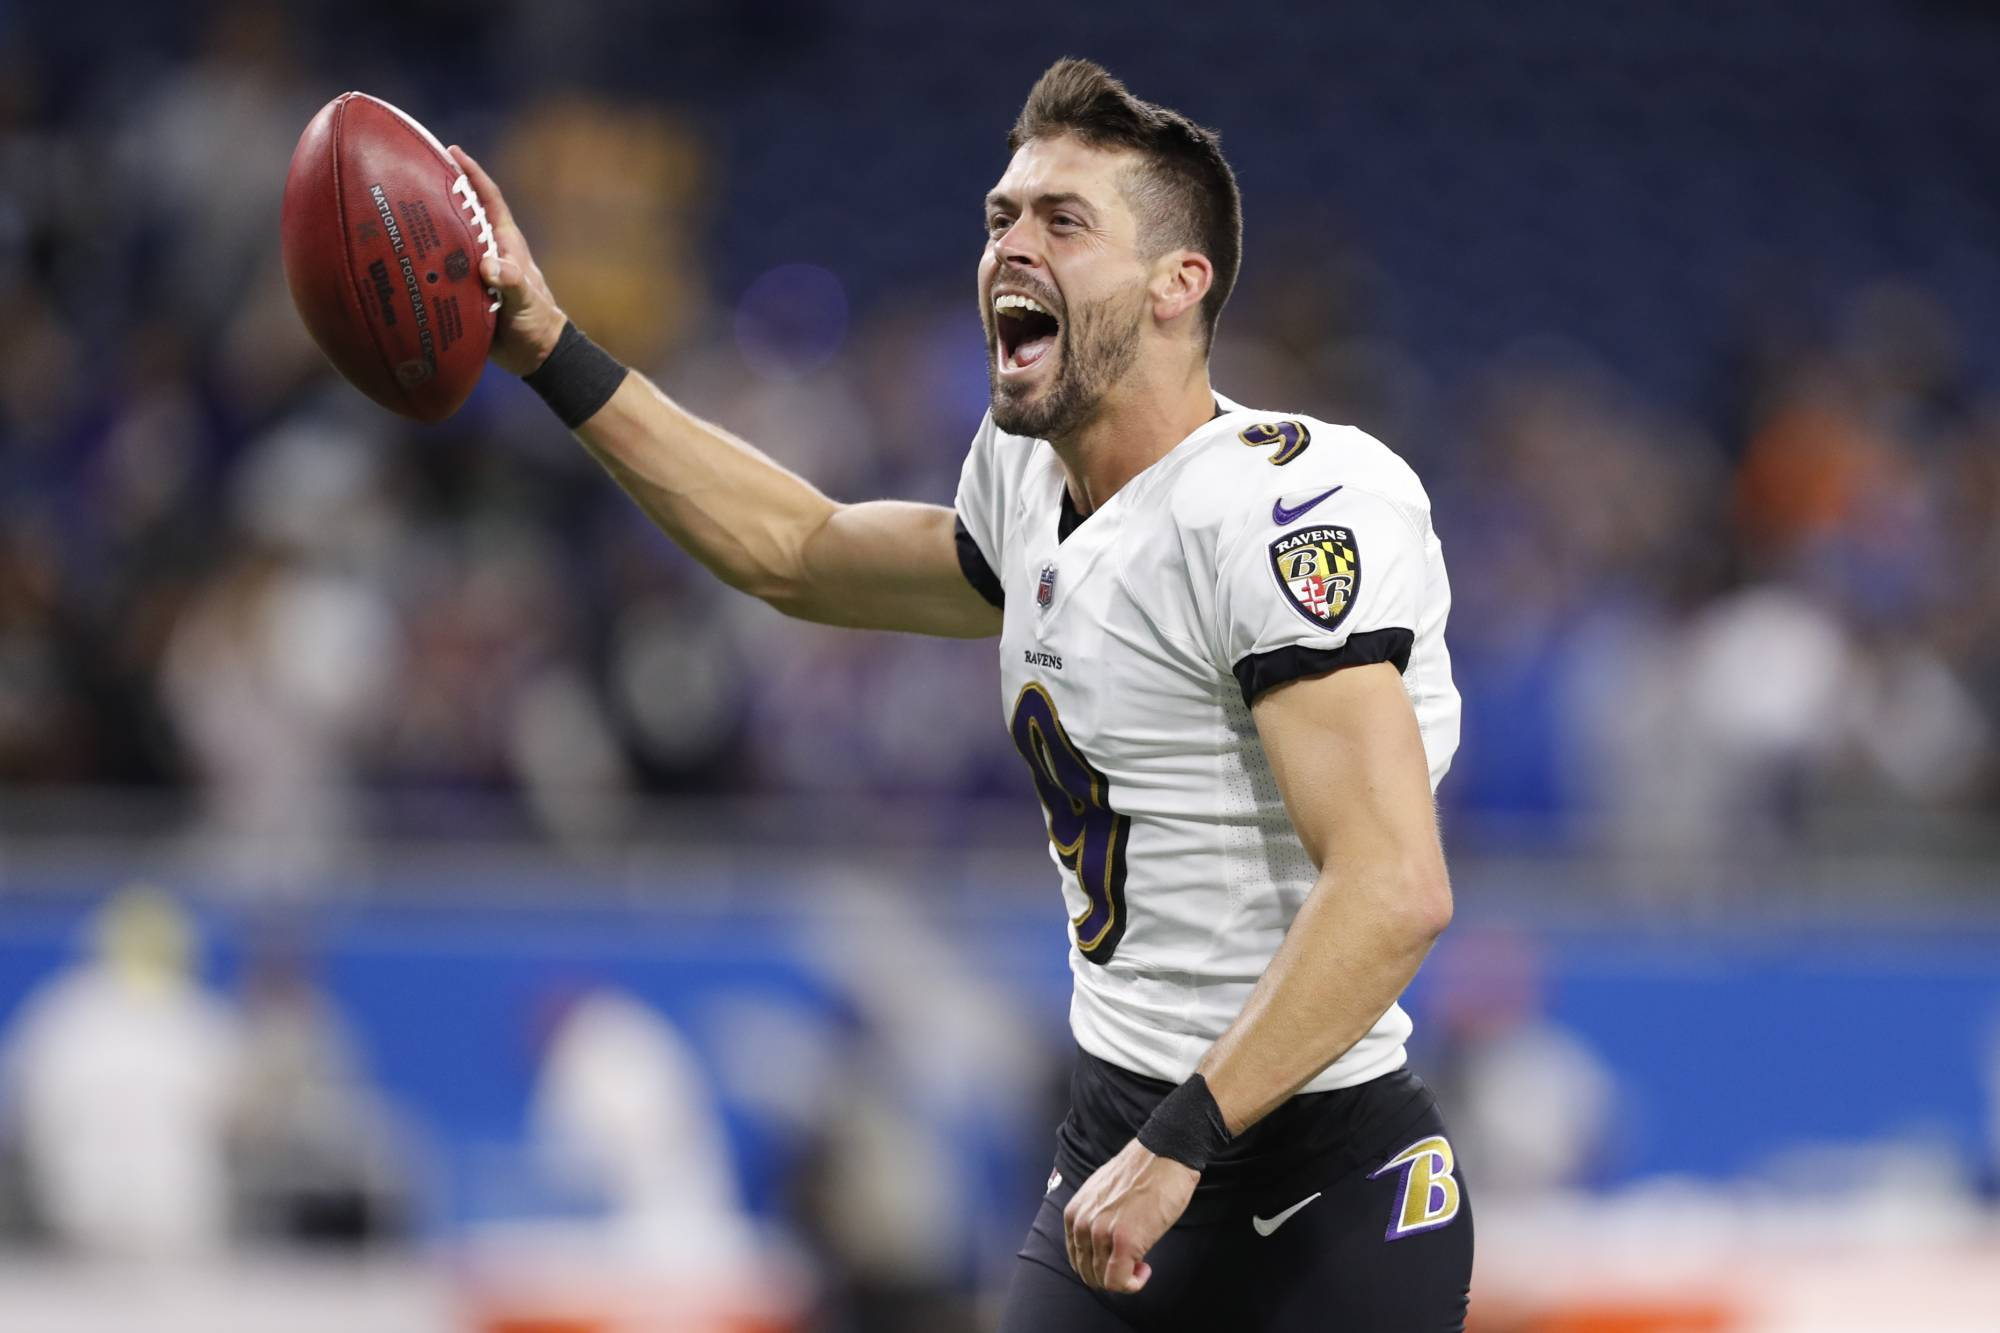



# Conclusion
<p>For this competition, we worked on ranking special teams players from the NFL.</p>
One of the most challenging part of this project was to handle the data, we had a lot of files to use and had to go through a lot of data cleaning.
<p>We focused on some of the most important positions in special teams and compared players by position.\\
To achieve this, we tried two different approaches to compare players: one comparing players' results with only one machine learning model and one comparing them with one model per player.</p>
<p>For the models predicting outcomes of different plays, we especially used XGBoost and we gathered with it interesting results when comparing players' performances.</p>
<p>Using our different approaches and with different features, we were able to rank "Kickers" from the NFL. Based on their past performances, we tested how each player would perform in some specific conditions in a sample of plays (the sample being the same for every player). In this way we were somewhat able to judge them fairly and not with the bias of the conditions of each player's plays.</p>
<p>For example, a kicker with an 85% accuracy might be ranked lower than someone with an 80% accuracy because the average distance of the first kicker's shots was of 20 yards when it was of 50 yards for the second one. And what really matters is how well the players would perform compared to the others in the same exact context.</p>
<p>Finally, for further improvement, we would continue working on other special teams positions, and especially the "punter" position for which we need deep learning models to do the predictions.</p>

# Image references
<div id="nfl_logo">1. NFL Logo, NFL: https://static.nfl.com/static/content/public/static/wildcat/assets/img/application-shell/shield/default.svg </div>
<div id="tucker"> 2. Justin tucker, japantimes: https://cdn-japantimes.com/wp-content/uploads/2021/09/np_file_114442.jpeg</div>
